In [24]:
import gymnasium as gym
from gymnasium.wrappers.vector import NormalizeObservation, NormalizeReward, NumpyToTorch
import torch

In [25]:
env = gym.make_vec('LunarLander-v3', num_envs = 4)
env = NormalizeObservation(env)
env = NormalizeReward(env)
env = NumpyToTorch(env)

In [26]:
env.observation_space

Box([[ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]], [[ 2.5        2.5       10.        10.         6.2831855 10.
   1.         1.       ]
 [ 2.5        2.5       10.        10.         6.2831855 10.
   1.         1.       ]
 [ 2.5        2.5       10.        10.         6.2831855 10.
   1.         1.       ]
 [ 2.5        2.5       10.        10.         6.2831855 10.
   1.         1.       ]], (4, 8), float32)

In [27]:
obs_sample = env.observation_space.sample()
obs_sample

array([[-0.24437913, -0.8514839 ,  6.7697887 , -5.7014003 ,  0.99907964,
        -5.5390973 ,  0.76438713,  0.8335268 ],
       [-0.5568898 , -2.4177022 ,  1.4982976 , -9.645968  , -5.6531787 ,
        -1.1427498 ,  0.09959971,  0.16790977],
       [-1.6343956 ,  0.4611477 ,  5.583099  ,  2.5178006 ,  2.9327445 ,
         6.5930395 ,  0.25891954,  0.11207388],
       [ 0.09017859,  2.2354476 ,  3.7540355 , -2.8570385 , -4.617812  ,
        -6.110767  ,  0.16484092,  0.0666474 ]], dtype=float32)

In [28]:
obs_sample.shape

(4, 8)

In [29]:
env.action_space

MultiDiscrete([4 4 4 4])

In [30]:
actions_sample = env.action_space.sample()
actions_sample

array([1, 3, 3, 1])

In [31]:
states, info = env.reset()
states

tensor([[ 1.0571, -0.2953,  1.4976, -0.4875, -1.1321, -1.4962,  0.0000,  0.0000],
        [-0.7589, -0.4600, -1.0752, -0.7563,  0.8128,  1.0742,  0.0000,  0.0000],
        [ 0.2079, -0.2890,  0.2946, -0.4771, -0.2227, -0.2943,  0.0000,  0.0000],
        [-0.5061,  1.0573, -0.7170,  1.7209,  0.5420,  0.7164,  0.0000,  0.0000]])

In [32]:
next_states, rewards, dones, terminated, _ = env.step(actions_sample)

In [33]:
next_states

tensor([[ 1.6116, -0.5969,  1.4842, -0.5291, -1.5156, -1.2187,  0.0000,  0.0000],
        [-1.3302, -0.8921, -1.0589, -0.8002,  1.2042,  0.7562,  0.0000,  0.0000],
        [ 0.2448, -0.5859,  0.3141, -0.5192, -0.4465, -0.6437,  0.0000,  0.0000],
        [-0.9362,  1.8168, -0.7383,  1.6758,  1.1818,  1.0938,  0.0000,  0.0000]])

In [34]:
rewards

tensor([ 0.0430,  0.0379, -2.3940, -1.0267], dtype=torch.float64)

In [35]:
dones # done is when state successfully finished or passed

tensor([False, False, False, False])

In [36]:
terminated # terminated is when agent failed 

tensor([False, False, False, False])

In [37]:
from src.ppo import *
import random
import numpy as np
from src.tune_hyperparams import return_obj
import optuna

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [38]:
actor = Actor(8, 4, 256).to(device)
critic = Critic(8, 1, 256).to(device)

In [39]:
obs_sample = torch.from_numpy(obs_sample).to(device)
dist = actor.forward(obs_sample)
dist

Categorical(logits: torch.Size([4, 4]))

In [40]:
test_sample = dist.sample()

In [41]:
dist.log_prob(test_sample)

tensor([-1.1903, -1.6344, -1.4620, -1.3390], grad_fn=<SqueezeBackward1>)

In [42]:
dist.log_prob(test_sample).exp()

tensor([0.3041, 0.1951, 0.2318, 0.2621], grad_fn=<ExpBackward0>)

In [43]:
critic.forward(obs_sample)

tensor([[-0.2565],
        [-0.0055],
        [-0.3858],
        [-0.3810]], grad_fn=<AddmmBackward0>)

In [44]:
# params = {
#     "actor_in_feats": (8, 8, "int"),
#     "actor_out_feats": (4, 4, "int"),
#     "actor_hs": (128, 512, "int"),
#     "critic_in_feats": (8, 8, "int"),
#     "critic_out_feats": (1, 1, "int"),
#     "critic_hs": (128, 512, "int"),
#     "epsilon": (0.1, 0.3, "float"),
#     "gamma": (0.95, 0.999, "float"),
#     "lambda": (0.9, 0.99, "float"),
#     "actor_lr": (1e-5, 1e-3, "float"),
#     "critic_lr": (1e-5, 1e-3, "float"),
#     "batch_size": (256, 1024, "int"),
#     "c1": (0.1, 1.0, "float"),
#     "c2": (0.001, 0.05, "float")
# }

# objective = return_obj(env, device, 100, 512, 4, train, params)
# sampler = optuna.samplers.TPESampler(multivariate = True, n_startup_trials = 2)
# study = optuna.create_study(direction = 'maximize', study_name = 'lunar lander tune', sampler = sampler)
# study.optimize(objective, n_trials = 30)

In [45]:
# study.best_params

In [46]:
actor = Actor(8, 4, 256).to(device)
critic = Critic(8, 1, 256).to(device)
agent = Agent(actor, critic, 0.2, 0.999, 0.98, 0.5, 0.01, 0.0003, 0.001, device, 64)

In [47]:
train(env, agent, 500, 512, 4, 'models/lunarlander_agent.pt', True) 

finished episode: 0
total reward: -113.55493805389857
number of steps: 512
---------------
new best model... saving...
finished episode: 1
total reward: -124.36922778688691
number of steps: 512
---------------
finished episode: 2
total reward: -87.59496445385597
number of steps: 512
---------------
new best model... saving...
finished episode: 3
total reward: -68.9542882014348
number of steps: 512
---------------
new best model... saving...
finished episode: 4
total reward: -74.41453575061271
number of steps: 512
---------------
finished episode: 5
total reward: -65.76803751745767
number of steps: 512
---------------
new best model... saving...
finished episode: 6
total reward: -62.9517047576492
number of steps: 512
---------------
new best model... saving...
finished episode: 7
total reward: -71.57718396806112
number of steps: 512
---------------
finished episode: 8
total reward: -75.12859857321727
number of steps: 512
---------------
finished episode: 9
total reward: -55.997192600059

Text(0, 0.5, 'reward')

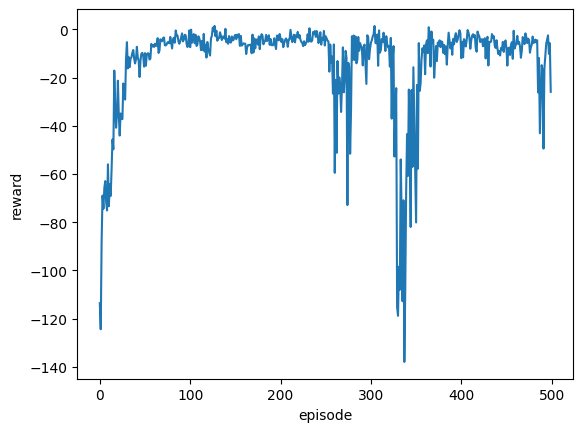

In [48]:
import matplotlib.pyplot as plt
plt.plot(agent.all_rewards)
plt.xlabel('episode')
plt.ylabel('reward')

In [49]:
# agent.save_agent('models/lunarlander_agent.pt')